In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import statsmodels.api as sm
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestRegressor
from   statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

In [2]:
oil_data = pd.read_csv('../b. Datasets/Oil Prices/Oil Prices.csv')

In [3]:
oil_data.columns

Index(['date', ' value'], dtype='object')

In [4]:
oil_data.rename(columns={" value": "Value"}, inplace=True)
oil_data.columns

Index(['date', 'Value'], dtype='object')

In [5]:
display(oil_data.head(2))
display(oil_data.tail(2))

,date,Value
0,01-01-2010,8.2
1,01-02-2010,8.4


,date,Value
90,01-07-2017,10.10
91,01-08-2017,10.14


In [6]:
date_feature = pd.date_range(start='01-01-2010', end='08-01-2017', freq='MS')
oil_data.drop(labels='date', axis=1, inplace=True)
oil_data.insert(loc=0, column='Date', value=date_feature)

In [7]:
oil_data.isna().sum()

Date     0
Value    0
dtype: int64

In [8]:
display(oil_data.head(2))
display(oil_data.tail(2))

,Date,Value
0,2010-01-01,8.2
1,2010-02-01,8.4


,Date,Value
90,2017-07-01,10.10
91,2017-08-01,10.14


In [9]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    92 non-null     datetime64[ns]
 1   Value   92 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 KB


In [10]:
oil_data.describe()

,Date,Value
count,92,92.000000
mean,2013-10-16 01:33:54.782608640,9.737283
min,2010-01-01 00:00:00,8.200000
25%,2011-11-23 12:00:00,9.500000
50%,2013-10-16 12:00:00,9.800000
75%,2015-09-08 12:00:00,10.100000
max,2017-08-01 00:00:00,10.630000
std,NaN,0.530958


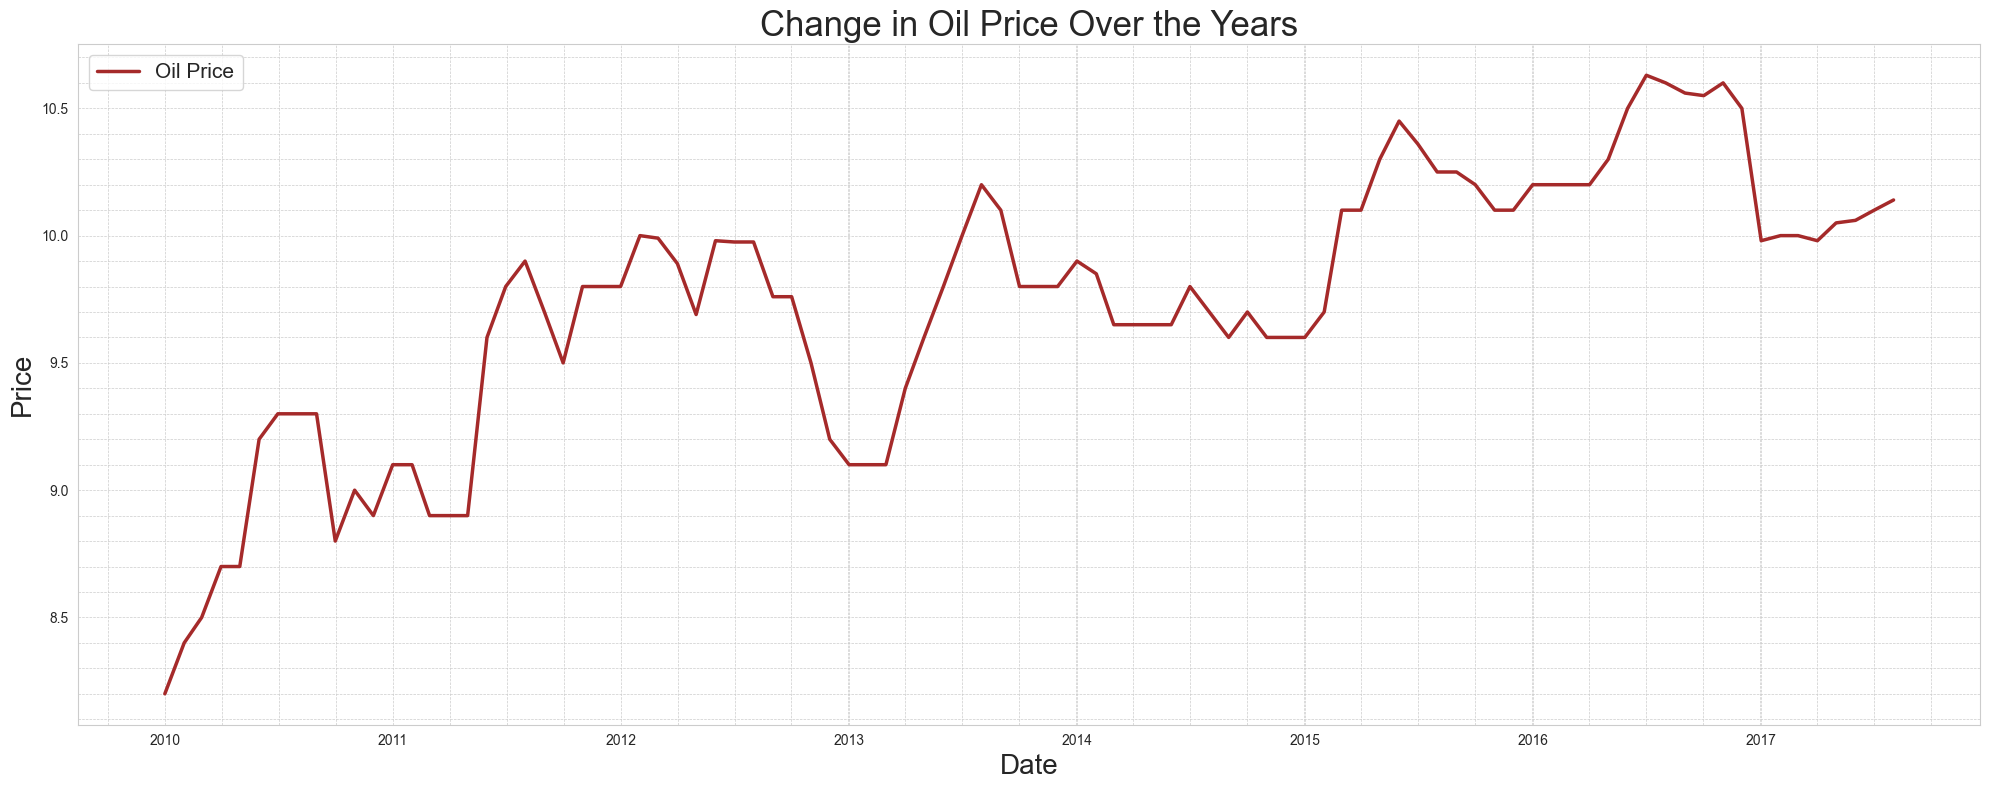

In [11]:
plt.figure(figsize=(20, 8))
sns.set_style('whitegrid')
sns.lineplot(data=oil_data, x='Date', y='Value', color='brown', linewidth=2.5)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Price", fontsize=20)
plt.title("Change in Oil Price Over the Years", fontsize=25)
plt.minorticks_on()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(['Oil Price'], loc='upper left', fontsize=15)
plt.tight_layout()
plt.show()

In [12]:
oil_data.set_index(keys='Date', inplace=True)

In [13]:
adf_test = adfuller(oil_data['Value'])

adf_result = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_result[f'Critical Value ({key})'] = value

print(adf_result)

if adf_result['p-value'] < 0.05:
    print("The data is stationary. Differencing is not required.")
else:
    print("The data is not stationary. Differencing is required.")

Test Statistic                 -2.824651
p-value                         0.054838
#Lags Used                      1.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64
The data is not stationary. Differencing is required.


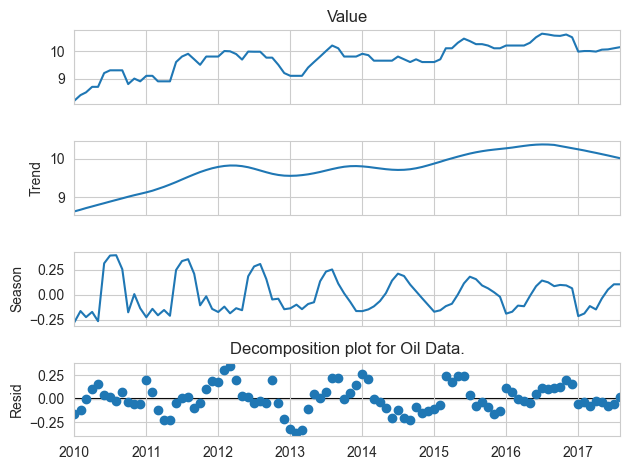

In [14]:
oil_data_series = oil_data['Value']

decomposition = STL(oil_data_series).fit()
decomposition.plot()
plt.title("Decomposition plot for Oil Data.")
plt.tight_layout()
plt.show()

In [15]:
train_end = datetime(2015, 8, 1)

train_data = oil_data[:train_end]
validation_data = oil_data[train_end + timedelta(days=31):]

In [16]:
display(train_data.head(2))
display(train_data.tail(2))
display(validation_data.head(2))
display(validation_data.tail(2))

,Value
Date,
2010-01-01,8.2
2010-02-01,8.4


,Value
Date,
2015-07-01,10.36
2015-08-01,10.25


,Value
Date,
2015-09-01,10.25
2015-10-01,10.20


,Value
Date,
2017-07-01,10.10
2017-08-01,10.14


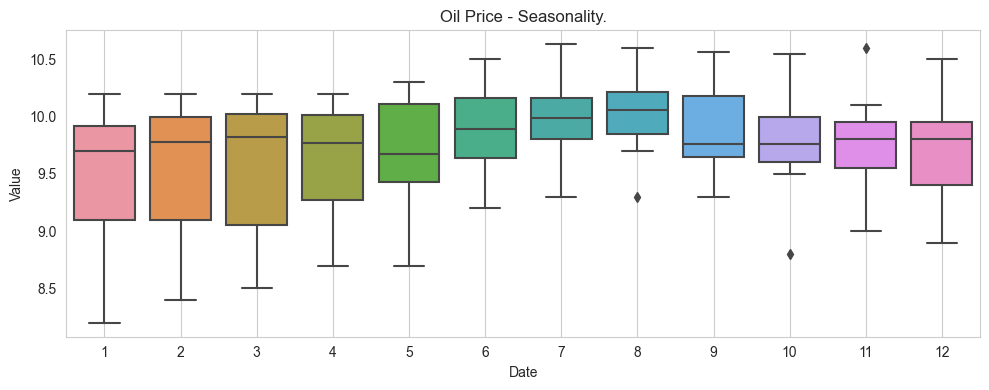

In [17]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=oil_data.index.month, y=oil_data['Value'])
plt.title('Oil Price - Seasonality.')
plt.grid()
plt.tight_layout()
plt.show()

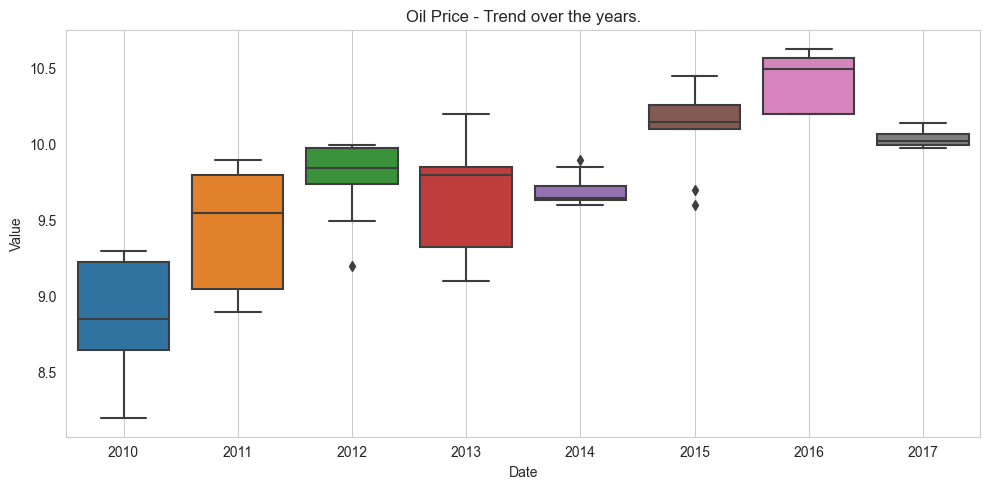

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=oil_data.index.year, y=oil_data['Value'])
plt.title('Oil Price - Trend over the years.')
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
p = q = range(0, 3)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))

model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [20]:
aic_df = pd.DataFrame(columns=['param','seasonal', 'AIC'])
aic_df

,param,seasonal,AIC


In [21]:
for param in pdq:
    for param_seasonal in model_pdq:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results_SARIMA = mod.fit()
            detail = pd.DataFrame({'param': [param], 
                                   'seasonal': [param_seasonal], 
                                   'AIC': [results_SARIMA.aic]})
            aic_df = pd.concat([aic_df, detail], ignore_index=True)
    print(f"Iteration complete for param value: {param}")
print("AIC calculation for entire grid is complete.")

Iteration complete for param value: (0, 1, 0)
Iteration complete for param value: (0, 1, 1)
Iteration complete for param value: (0, 1, 2)
Iteration complete for param value: (1, 1, 0)
Iteration complete for param value: (1, 1, 1)
Iteration complete for param value: (1, 1, 2)
Iteration complete for param value: (2, 1, 0)
Iteration complete for param value: (2, 1, 1)
Iteration complete for param value: (2, 1, 2)
AIC calculation for entire grid is complete.


In [22]:
aic_df.sort_values(by='AIC', inplace=True)
aic_df

,param,seasonal,AIC
6,"(0, 1, 0)","(2, 1, 0, 12)",-13.456949
7,"(0, 1, 0)","(2, 1, 1, 12)",-13.324365
15,"(0, 1, 1)","(2, 1, 0, 12)",-11.698820
16,"(0, 1, 1)","(2, 1, 1, 12)",-11.616154
33,"(1, 1, 0)","(2, 1, 0, 12)",-10.468946
...,...,...,...
18,"(0, 1, 2)","(0, 1, 0, 12)",-1.865261
49,"(1, 1, 2)","(1, 1, 1, 12)",-1.686203
63,"(2, 1, 1)","(0, 1, 0, 12)",-0.722891
45,"(1, 1, 2)","(0, 1, 0, 12)",0.135556


In [23]:
sarimax_model = sm.tsa.statespace.SARIMAX(train_data,
                                            order=aic_df['param'][0],
                                            seasonal_order=aic_df['seasonal'][0],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                   68
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                   2.158
Date:                            Tue, 19 Nov 2024   AIC                             -2.316
Time:                                    15:11:18   BIC                             -0.327
Sample:                                01-01-2010   HQIC                            -1.549
                                     - 08-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0540      0.011      4.800      0.000       0.032       0.076
===================================================================================
Ljung-Box (L1) (Q):                   3.61   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.06   Prob(JB):                         0.81
Heteroskedasticity (H):               1.36   Skew:                             0.16
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
sarimax_forecast = sarimax_results.forecast(steps=24)

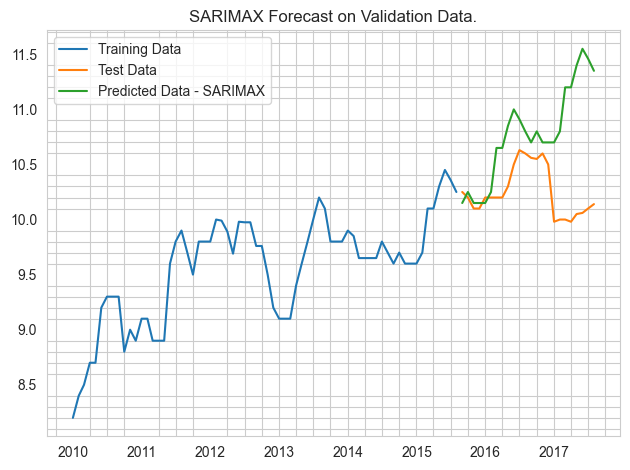

In [25]:
plt.plot(train_data,label='Training Data')
plt.plot(validation_data,label='Test Data')
plt.plot(validation_data.index, sarimax_forecast,label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.title('SARIMAX Forecast on Validation Data.')
plt.minorticks_on()
plt.grid(which='both')
plt.tight_layout()
plt.show()

In [26]:
holt_winters_forecast = ExponentialSmoothing(train_data, 
                                             trend='multiplicative', 
                                             seasonal='multiplicative', 
                                             initialization_method='estimated')
holt_winters_forecast = holt_winters_forecast.fit(optimized=True)
holt_winters_forecast.summary()

Dep. Variable:,Value,No. Observations:,68
Model:,ExponentialSmoothing,SSE,1.630
Optimized:,True,AIC,-221.704
Trend:,Multiplicative,BIC,-186.192
Seasonal:,Multiplicative,AICC,-207.745
Seasonal Periods:,12,Date:,"Tue, 19 Nov 2024"
Box-Cox:,False,Time:,15:11:20
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


In [27]:
holt_winters_forecast =  holt_winters_forecast.forecast(len(validation_data))

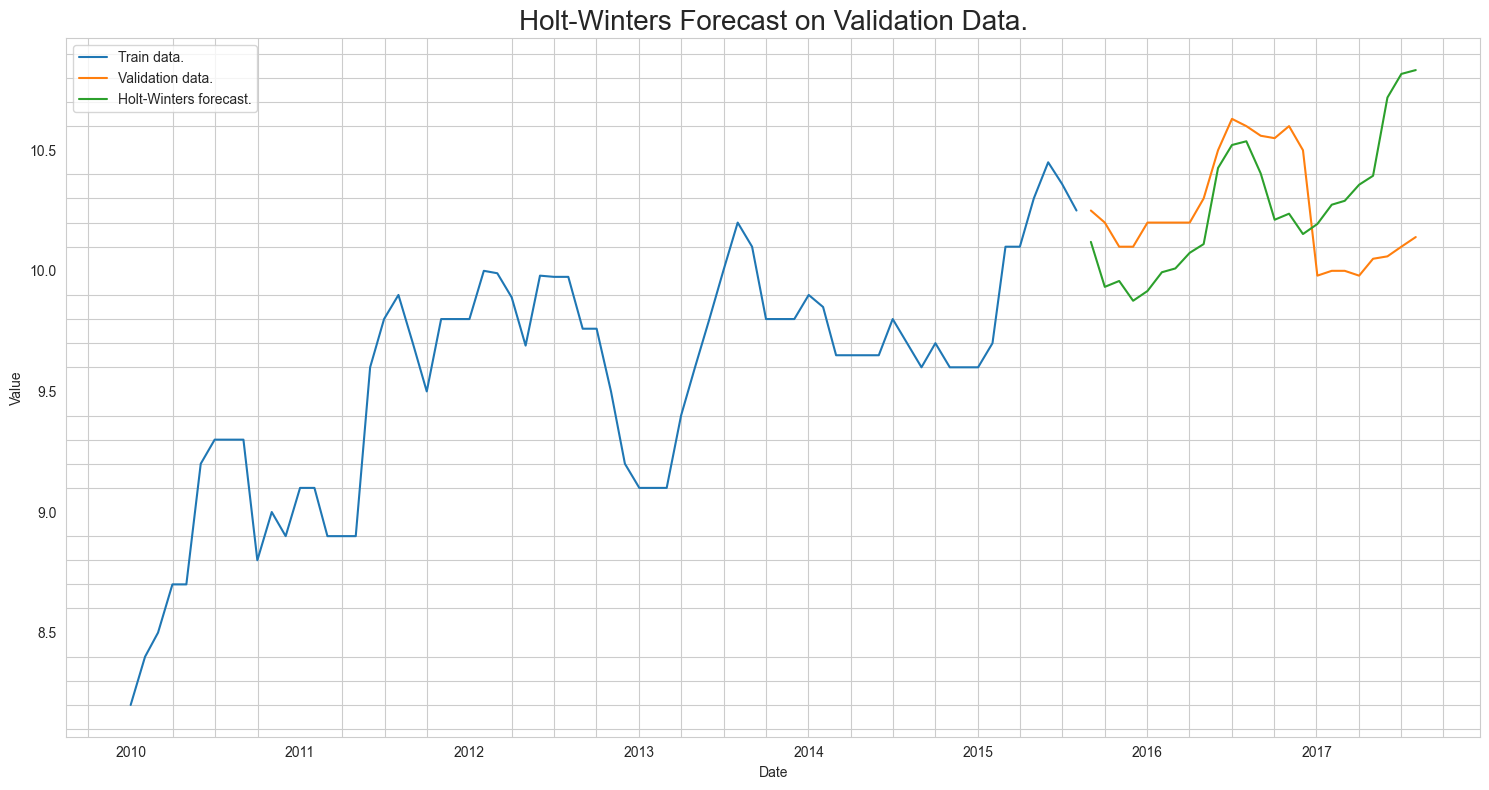

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(train_data, label='Train data.')
plt.plot(validation_data, label='Validation data.')
plt.plot(holt_winters_forecast, label='Holt-Winters forecast.')

plt.legend(loc='best')
plt.title('Holt-Winters Forecast on Validation Data.', fontsize=20)
plt.xlabel("Date")
plt.ylabel("Value")
plt.minorticks_on()
plt.grid(which='both')
plt.tight_layout()
plt.show()

In [29]:
validation_values = validation_data.values

In [30]:
holt_winters_rmse = mean_squared_error(validation_values, holt_winters_forecast, squared=False)
print(f"Holt-Winters Model RMSE: {holt_winters_rmse}")

Holt-Winters Model RMSE: 0.33373192911250577


In [31]:
stacked_features = pd.DataFrame({
    'SARIMAX': sarimax_forecast,
    'HoltWinters': holt_winters_forecast
})

meta_model = RandomForestRegressor()

meta_model.fit(stacked_features, validation_values)

stacked_predictions = meta_model.predict(stacked_features)

rmse = np.sqrt(mean_squared_error(validation_values, stacked_predictions))
print(f"Stacked Model RMSE: {rmse}")

Stacked Model RMSE: 0.07696071779377779


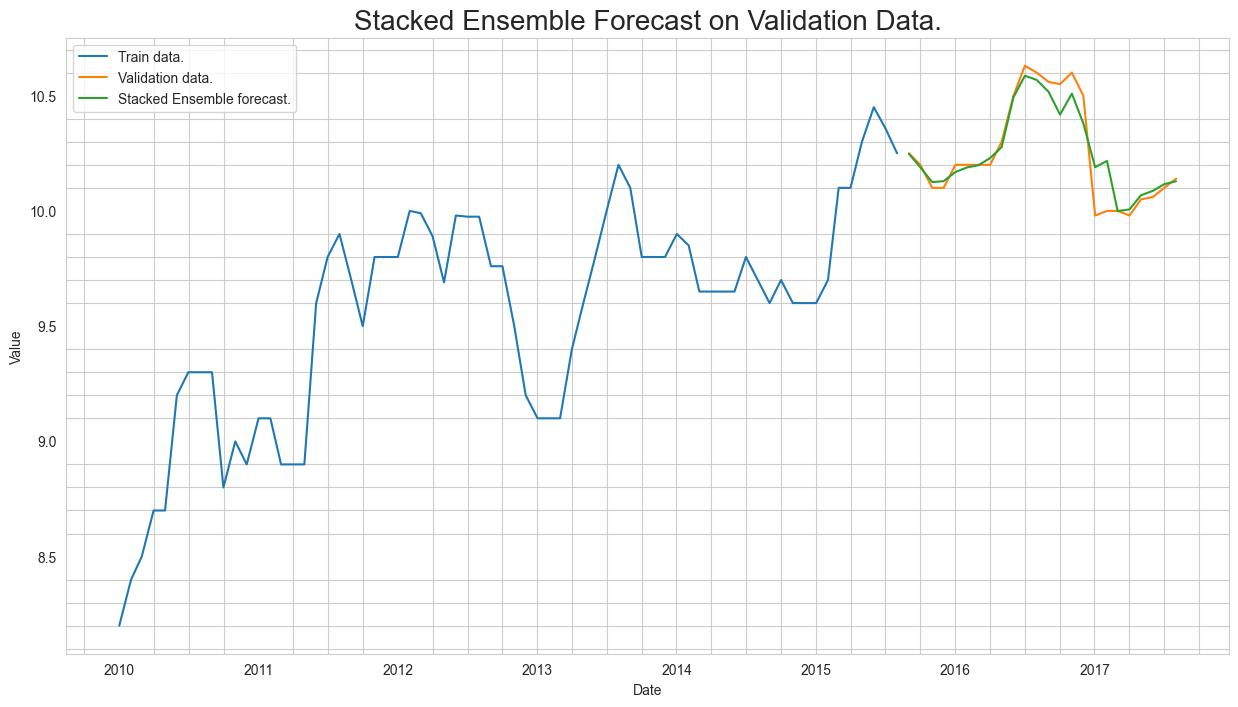

In [32]:
plt.figure(figsize=(15, 8))
plt.plot(train_data, label='Train data.')
plt.plot(validation_data, label='Validation data.')
plt.plot(validation_data.index, stacked_predictions, label='Stacked Ensemble forecast.')

plt.legend(loc='best')
plt.title('Stacked Ensemble Forecast on Validation Data.', fontsize=20)
plt.xlabel("Date")
plt.ylabel("Value")
plt.minorticks_on()
plt.grid(which='both')
plt.show()

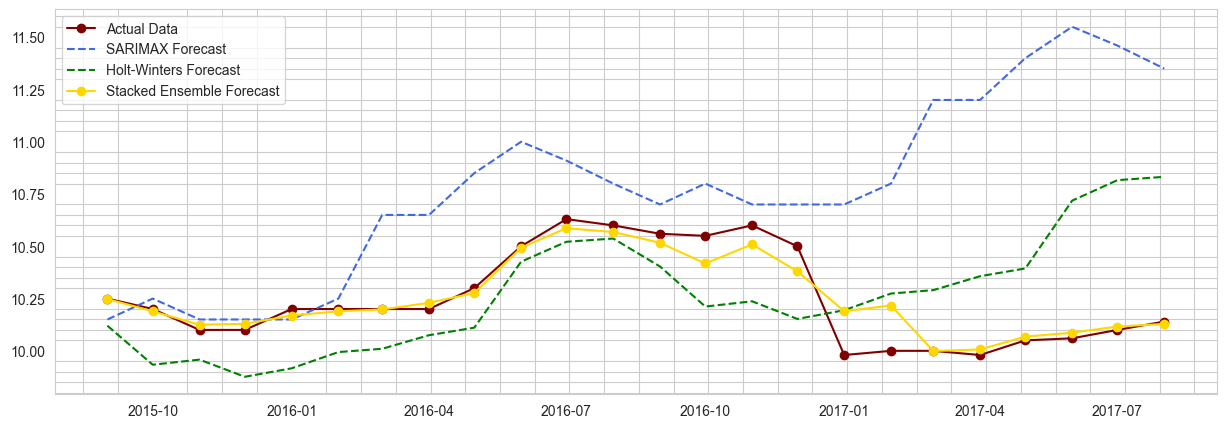

In [33]:
plt.figure(figsize=(15, 5))

plt.plot(validation_data, label='Actual Data', color='maroon', marker='o')
plt.plot(validation_data.index, sarimax_forecast, label='SARIMAX Forecast', color='royalblue', linestyle='--')
plt.plot(validation_data.index, holt_winters_forecast, label='Holt-Winters Forecast', color='green', linestyle='--')
plt.plot(validation_data.index, stacked_predictions, label='Stacked Ensemble Forecast', color='gold', marker='o')
plt.legend(loc='best')
plt.minorticks_on()
plt.grid(which='both')
plt.show()

In [34]:
stacked_mape = mean_absolute_percentage_error(validation_values, stacked_predictions) * 100
sarimax_mape = mean_absolute_percentage_error(validation_values, sarimax_forecast.values) * 100
holt_winters_mape = mean_absolute_percentage_error(validation_values, holt_winters_forecast.values) * 100

print(f"Stacked Model MAPE: {stacked_mape:.2f}%")
print(f"SARIMAX MAPE: {sarimax_mape:.2f}%")
print(f"Holt-Winters MAPE: {holt_winters_mape:.2f}%")

Stacked Model MAPE: 0.47%
SARIMAX MAPE: 5.27%
Holt-Winters MAPE: 2.77%


##### We've now got a much better forecast. We can go forward with the forcast for future now that validation is clear.

In [35]:
sarimax_model = sm.tsa.statespace.SARIMAX(oil_data, 
                                          order=aic_df['param'][0], 
                                          seasonal_order=aic_df['seasonal'][0], 
                                          enforce_invertibility=False)
sarimax_results = sarimax_model.fit()
sarimax_results.summary()
sarimax_forecast = sarimax_results.forecast(steps=24)

In [36]:
holt_winters_forecast = ExponentialSmoothing(oil_data, 
                                             trend='multiplicative', 
                                             seasonal='multiplicative', 
                                             initialization_method='estimated')
holt_winters_forecast = holt_winters_forecast.fit(optimized=True)
holt_winters_forecast.summary()
holt_winters_forecast =  holt_winters_forecast.forecast(steps=24)

In [37]:
stacked_features = pd.DataFrame({
    'SARIMAX': sarimax_forecast,
    'HoltWinters': holt_winters_forecast
})

meta_model = RandomForestRegressor()
meta_model.fit(stacked_features, validation_values)
stacked_predictions = meta_model.predict(stacked_features)

In [38]:
test_dates = pd.date_range(start=oil_data.index[-1] + timedelta(days=31), 
                           end=oil_data.index[-1] + timedelta(days=365*2), 
                           freq='MS')
test_dates[0], test_dates[-1]

(Timestamp('2017-09-01 00:00:00'), Timestamp('2019-08-01 00:00:00'))

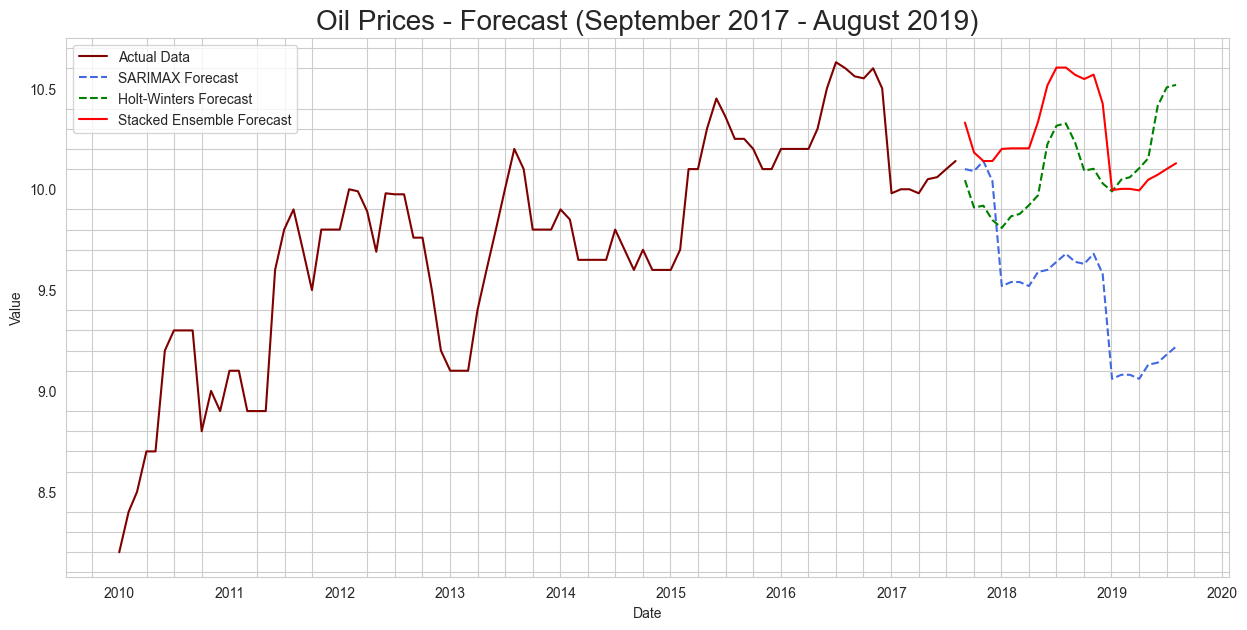

In [39]:
plt.figure(figsize=(15, 7))

plt.plot(oil_data, label='Actual Data', color='maroon')
plt.plot(sarimax_forecast, label='SARIMAX Forecast', color='royalblue', linestyle='--')
plt.plot(holt_winters_forecast, label='Holt-Winters Forecast', color='green', linestyle='--')
plt.plot(test_dates, stacked_predictions, label='Stacked Ensemble Forecast', color='red')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Oil Prices - Forecast (September 2017 - August 2019)', fontsize=20)
plt.minorticks_on()
plt.grid(which='both')
plt.show()

In [40]:
submission_dataframe = pd.DataFrame({
    'Date': test_dates,
    'Value': stacked_predictions
})
submission_dataframe.sort_values(by="Date", inplace=True)

In [41]:
submission_dataframe_file = ('../d. Output Files/OilPrices/' + 'OilPrices_Prediction.csv')
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: OilPrices_Prediction.csv
